In [33]:
#### SIMILARITY

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import seaborn as sns
import matplotlib.pyplot as plt
import collections as c
from ast import literal_eval
import matplotlib.patches as mpatches


In [39]:


def normalize_distances(distances):
        min_distance = min(distances)
        max_distance = max(distances)
        return [(d - min_distance) / (max_distance - min_distance) for d in distances]

def distance_calc(data):

    ids = list(set(data['groupId']))

    avg_sim = []
    avg_corr = []
    avg_dist = []
    for val in ids:
        df_members = df.loc[df['groupId'] == val]
        df_members.set_index("user_id", inplace=True)
        df_members = df_members.iloc[:, :-1]


        distance_matrix = pd.DataFrame([[euclidean(u, v) for v in df_members.values] for u in df_members.values])


        n_users = df_members.shape[0]
        dists = []
        for i in range(n_users):
            for j in range(i + 1, n_users):
                dists.append(distance_matrix.iloc[i, j])

        avg_dist.append(np.mean(dists))

    return normalize_distances(avg_dist)


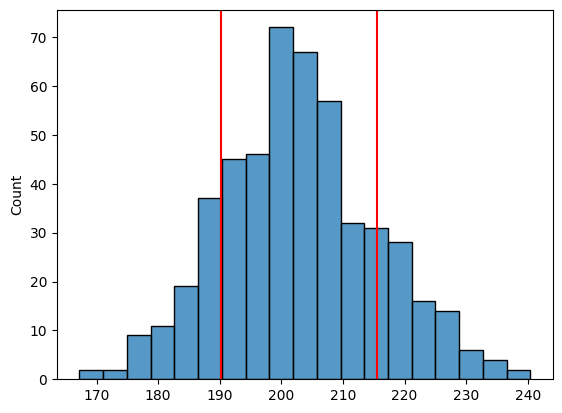

25 Counter({'Neutral': 336, 'Dissimilar': 85, 'Similar': 79})


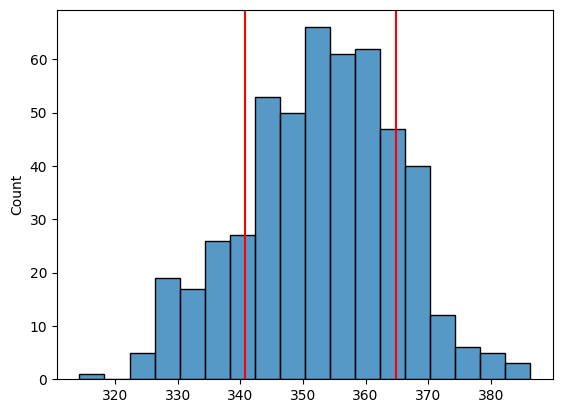

75 Counter({'Neutral': 340, 'Dissimilar': 80, 'Similar': 80})


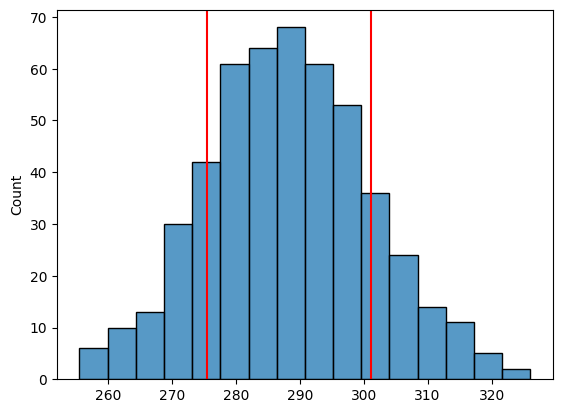

50 Counter({'Neutral': 346, 'Dissimilar': 77, 'Similar': 77})


In [ ]:
####################
total = 2000
num_members = [4]


num_items = [25, 75, 50]  
##################
## Datasets are named after num_members, num_items and total groups

for num in num_items:
    file = f'group_data/v3-groups_{num_members}members_[{num}]items_totalgroups{total}.csv'
    df = pd.read_csv(file)
    df = df.head(2000)
    normalized_distances =  distance_calc(df)

    mean_score = np.mean(normalized_distances)
    std_score = np.std(normalized_distances)

    categories = ["Similar" if x < mean_score - std_score else 
              "Dissimilar" if x > mean_score + std_score else 
              "Neutral" for x in normalized_distances]


    ax = sns.histplot(normalized_distances)
    ax.axvline(mean_score + std_score, color='r')
    ax.axvline(mean_score - std_score, color='r')
    plt.show()
    print(num, c.Counter(categories))

    if num == 25:
        result_df25 = pd.read_csv('your_25_item_results_file')
        if len(result_df25) > 500:
            result_df25 = result_df25.head(500)

        result_df25['categories'] = categories 
    elif num == 50:
        result_df50 = pd.read_csv('your_50_item_results_file')
        if len(result_df50) > 500:
            result_df50 = result_df50.head(500)

        result_df50['categories'] = categories 
    else:
        result_df75 = pd.read_csv('your_75_item_results_file')
        if len(result_df75) > 500:
            result_df75 = result_df75.head(500)

        result_df75['categories'] = categories 


In [28]:
def dcg(relevance_scores, k):
    rel = np.array(relevance_scores, dtype=float)[:k]
    if len(rel) == 0:
        return 0.0

    discounts = np.log2(np.arange(2, len(rel) + 1))
    return rel[0] + np.sum(rel[1:] / discounts) if len(rel) > 1 else rel[0]

def ndcg(relevance_scores, k):
    if k == 0 or len(relevance_scores) == 0:
        return 0.0

    actual_dcg = dcg(relevance_scores, k)
    ideal_dcg = dcg(sorted(relevance_scores, reverse=True), k)

    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0.0

def get_relevance_scores(list1, list2):
    """
    Binary relevance. 1 if correct, 0 if not.
    """
    return [1 if item in list2 else 0 for item in list1]

In [30]:
def calc_deltas(data):
    temp = data[['vector_random','vector_llama', 'vector_mistral', 'vector_gemma', 'vector_phi',
                  'vector_ADD', 'vector_MPL', 'vector_LMS', 'vector_APP', 'categories']]
    temp.columns = ['Random','Llama', 'Mistral', 'Gemma','Phi','ADD', 'MPL', 'LMS', 'APP', 'categories']

    methods = ['Random', 'Llama', 'Mistral', 'Gemma', 'Phi','ADD', 'MPL', 'LMS', 'APP']

    result_df = temp
    category_results = {'Similar': {}, 'Dissimilar': {}, 'Neutral': {}}

    for category in ['Similar', 'Dissimilar', 'Neutral']:
        category_df = result_df[result_df['categories'] == category]  
        category_ndcg_sums = {pair: 0 for pair in [(m, s) for m in ['Random', 'Llama', 'Mistral', 'Gemma', 'Phi']
                                               for s in ['ADD', 'MPL', 'LMS', 'APP']]} 
        count = 0  
        for _, row in category_df.iterrows():
            vectors = {m: literal_eval(row[m]) for m in methods}
        
            if all(len(vectors[m]) == len(vectors[methods[0]]) for m in methods):
                for model in ['Random', 'Llama', 'Mistral', 'Gemma', 'Phi']:
                    for strategy in ['ADD', 'MPL', 'LMS', 'APP']:
                        pair = (model, strategy)
                        rel_ij = get_relevance_scores(vectors[model], vectors[strategy])
                        ndcg10_ij = ndcg(rel_ij, 10)
                        category_ndcg_sums[pair] += ndcg10_ij 

                count += 1
    
        avg_ndcg = {pair: score / count if count > 0 else 0 for pair, score in category_ndcg_sums.items()}
    
        category_results[category] = avg_ndcg

    delta_results = []

    for model in ['Random', 'Llama', 'Mistral', 'Gemma', 'Phi']:  
        for strategy in ['ADD', 'MPL', 'LMS', 'APP']:  

            avg_similar = category_results['Similar'].get((model, strategy), 0)
            avg_dissimilar = category_results['Dissimilar'].get((model, strategy), 0)
            avg_neutral = category_results['Neutral'].get((model, strategy), 0)
        
            delta_similar = avg_similar - avg_neutral
            delta_dissimilar = avg_dissimilar - avg_neutral
            delta = avg_similar - avg_dissimilar
        
            delta_results.append({
            'Model': model,
            'Strategy': strategy,
            'Avg_NDCG_Similar': avg_similar,
            'Avg_NDCG_Dissimilar': avg_dissimilar,
            'Avg_NDCG_Neutral': avg_neutral,
            'Delta_Similar': delta_similar,
            'Delta_Dissimilar': delta_dissimilar,
            'Delta_groups': delta
            })

        final_df = pd.DataFrame(delta_results)

    final_df_grouped = final_df.groupby(['Model', 'Strategy']).agg({
    'Avg_NDCG_Similar': 'mean',
    'Avg_NDCG_Dissimilar': 'mean',
    'Avg_NDCG_Neutral': 'mean',
    'Delta_Similar': 'mean',
    'Delta_Dissimilar': 'mean',
    'Delta_groups': 'mean'
    }).reset_index()
    return final_df_grouped

In [32]:


final_df_grouped25 = calc_deltas(result_df25)
final_df_grouped50 = calc_deltas(result_df50)
final_df_grouped75 = calc_deltas(result_df75)

final_df_grouped25['Item_Group'] = '25 items'
final_df_grouped50['Item_Group'] = '50 items'
final_df_grouped75['Item_Group'] = '75 items'

final_df_combined = pd.concat([final_df_grouped25, final_df_grouped50, final_df_grouped75])

final_df_combined.reset_index(drop=True, inplace=True)

final_df_melted = final_df_combined.melt(id_vars=['Item_Group', 'Model'],
                                          value_vars=['Delta_Similar', 'Delta_Dissimilar'],
                                          var_name='Delta_Type', value_name='Delta')



In [37]:
final_df_combined.head(10)

,Model,Strategy,Avg_NDCG_Similar,Avg_NDCG_Dissimilar,Avg_NDCG_Neutral,Delta_Similar,Delta_Dissimilar,Delta_groups,Item_Group
0,Gemma,ADD,0.922520,0.872094,0.910431,0.012089,-0.038338,0.050426,25 items
1,Gemma,APP,0.899173,0.847071,0.880596,0.018577,-0.033525,0.052102,25 items
2,Gemma,LMS,0.803226,0.729799,0.776329,0.026897,-0.046530,0.073427,25 items
3,Gemma,MPL,0.956855,0.943454,0.957043,-0.000188,-0.013589,0.013401,25 items
4,Llama,ADD,0.947683,0.911527,0.922660,0.025023,-0.011133,0.036157,25 items
5,Llama,APP,0.882144,0.827116,0.864375,0.017770,-0.037259,0.055028,25 items
6,Llama,LMS,0.870859,0.808917,0.816263,0.054596,-0.007346,0.061942,25 items
7,Llama,MPL,0.893122,0.839238,0.887369,0.005753,-0.048130,0.053884,25 items
8,Mistral,ADD,0.910554,0.869812,0.884957,0.025597,-0.015145,0.040742,25 items
9,Mistral,APP,0.852027,0.833416,0.838809,0.013219,-0.005393,0.018612,25 items


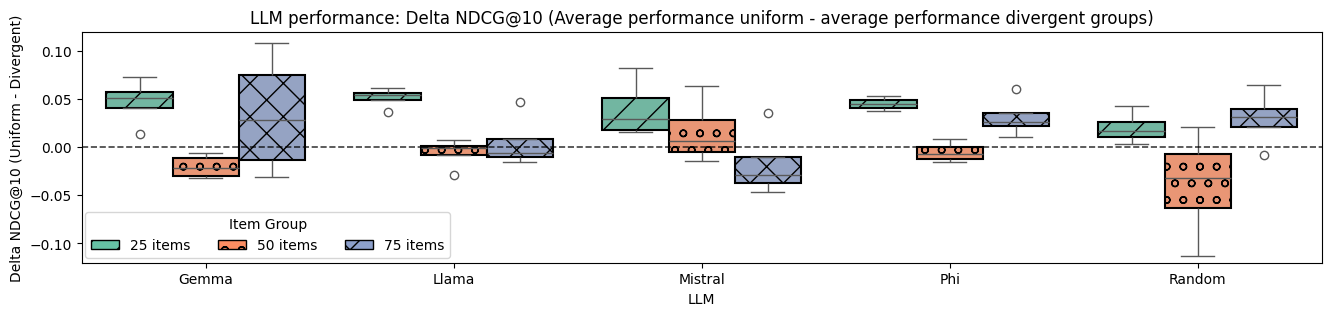

In [38]:
final_df_melted = final_df_combined.melt(id_vars=['Item_Group', 'Model'],
                                          value_vars=['Delta_groups'],
                                          var_name='Delta_Type', value_name='Delta')

hatch_patterns = {"25 items": "/", "50 items": "o", "75 items": "x"}

colors = sns.color_palette("Set2", n_colors=len(hatch_patterns))
plt.figure(figsize=(16, 3))

g = sns.boxplot(
    x="Model", y="Delta", hue="Item_Group", data=final_df_melted,
    palette=colors, dodge=True, boxprops={'edgecolor': 'black'}, patch_artist=True
)
hue_order = g.get_legend().get_texts()
hue_order = [t.get_text() for t in hue_order]  
num_models = len(final_df_melted["Model"].unique())  

for i, patch in enumerate(g.patches):
    group_idx = i // num_models  #
    item_group = hue_order[group_idx % len(hue_order)]  
    if item_group in hatch_patterns:
        patch.set_hatch(hatch_patterns[item_group])  
        patch.set_edgecolor("black")
        patch.set_linewidth(1.5)


legend_patches = [
    mpatches.Patch(facecolor=colors[i], edgecolor="black", hatch=hatch_patterns[label], label=label)
    for i, label in enumerate(hue_order)
]

plt.legend(handles=legend_patches, title="Item Group", ncol=3, loc='upper center', bbox_to_anchor=(0.15, 0.25))
plt.axhline(0, color='black', ls='--', lw='1.2', alpha=0.75)
plt.xlabel('LLM')
plt.ylabel('Delta NDCG@10 (Uniform - Divergent)')
plt.title("LLM performance: Delta NDCG@10 (Average performance uniform - average performance divergent groups)")
plt.ylim(-0.12, 0.12)
plt.savefig('delta_boxplots.png', dpi=500, bbox_inches='tight')
plt.show()